In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms.community import louvain_communities
import numpy as np
import matplotlib.dates as mdates
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder


# --- CONFIGURATION ---

DATA_PATH = 'data'

# 1. LOAD MAPPINGS 
ent_df = pd.read_csv(os.path.join(DATA_PATH, 'entity2id.txt'), sep='\t', names=['name', 'id', 'type', 'subtype'])
ent_map = dict(zip(ent_df['id'], ent_df['name']))
# Also recreate the type map for later
type_map = dict(zip(ent_df['id'], ent_df['type']))

rel_df = pd.read_csv(os.path.join(DATA_PATH, 'relation2id.txt'), sep='\t', names=['name', 'id'])
rel_map = dict(zip(rel_df['id'], rel_df['name']))

time_df = pd.read_csv(os.path.join(DATA_PATH, 'time2id.txt'), sep=',', header=0, names=['id', 'date'])
time_map = dict(zip(time_df['id'], time_df['date']))


# --- 2. LOAD ALL THREE SPLITS ---
def load_split(filename):
    path = os.path.join(DATA_PATH, filename)
    # Load raw IDs
    temp_df = pd.read_csv(path, sep='\t', names=['sub_id', 'rel_id', 'obj_id', 'time_id', 'ignore'])
    return temp_df

# Load them individually
raw_train = load_split('train.txt')
raw_valid = load_split('valid.txt')
raw_test  = load_split('test.txt')

# Combine them into one big list
df_raw_all = pd.concat([raw_train, raw_valid, raw_test], ignore_index=True)

# --- 3. TRANSLATE TO READABLE TEXT ---

def create_df(raw):
    df = pd.DataFrame()
    df['Date'] = pd.to_datetime(raw['time_id'].map(time_map), errors='coerce')
    df['Subject'] = raw['sub_id'].map(ent_map)
    df['Relation'] = raw['rel_id'].map(rel_map)
    df['Object'] = raw['obj_id'].map(ent_map)
    df['Subject_Type'] = raw['sub_id'].map(type_map)
    return df


df = create_df(df_raw_all)
print(df.head())

# Clean up any bad dates
df = df.dropna(subset=['Date'])

print("\nSUCCESS! Full Dataset Loaded.")
print(f"Total Events: {len(df)}")
print(f"Time Range: {df['Date'].min().date()} to {df['Date'].max().date()}")


        Date                         Subject         Relation  \
0 2018-01-07  President Trump Administration          Control   
1 2018-01-07                 Wells Fargo Co.           Impact   
2 2018-01-07                       Australia  Participates_In   
3 2018-01-07                   Manufacturing        Relate_To   
4 2018-01-07                   United States       Operate_In   

                 Object Subject_Type  
0          Volcker rule      ORG/GOV  
1  U.S. Federal Reserve         COMP  
2           S&P/ASX 200          GPE  
3    Economic Indicator       SECTOR  
4            Oil market          GPE  

SUCCESS! Full Dataset Loaded.
Total Events: 144062
Time Range: 2018-01-07 to 2020-05-31


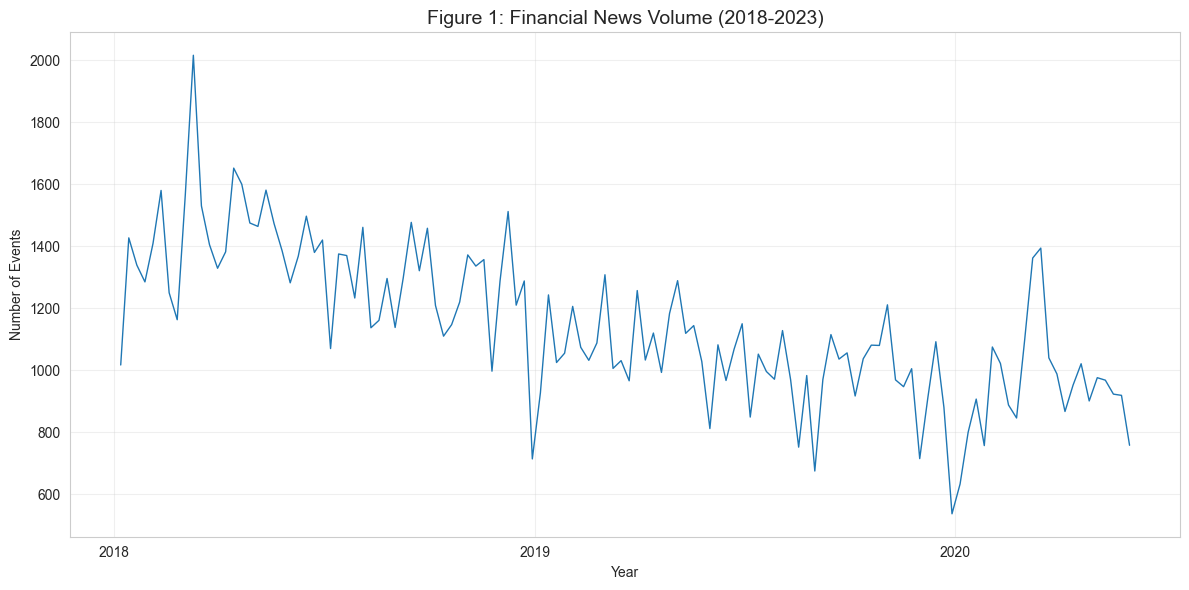

C:\Users\Samuele\AppData\Local\Temp\ipykernel_15260\1507617713.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_subjects.values, y=top_subjects.index, palette='viridis')


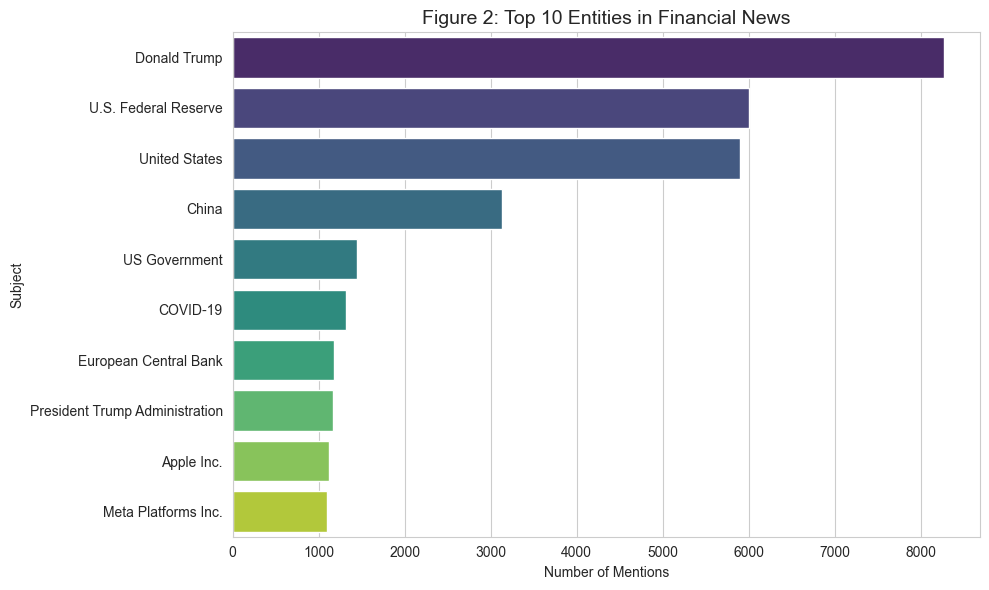

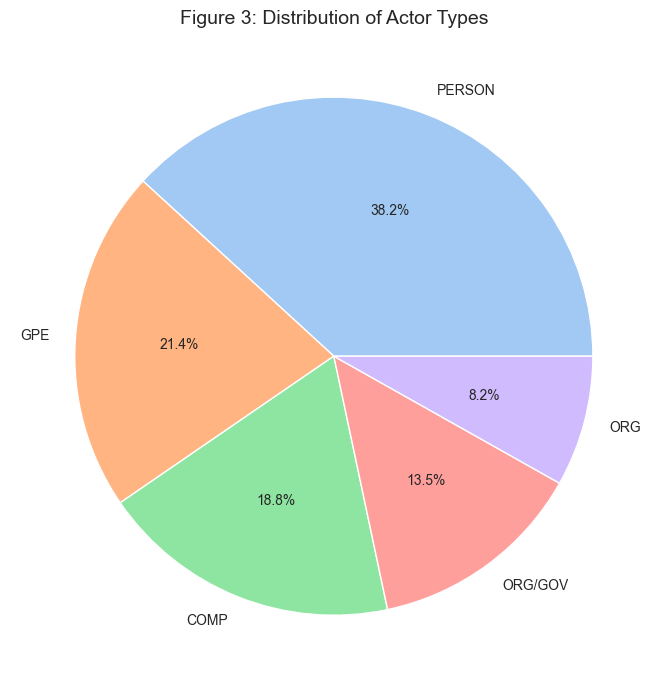

In [10]:
#--- VISUALIZATIONS ---

# Set a nice style for the plots
sns.set_style("whitegrid")

# 1. FORCE the conversion to be safe
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# 2. Prepare the data
# Drop any rows where the date failed to convert
clean_df = df.dropna(subset=['Date']) 
daily_counts = clean_df['Date'].value_counts().sort_index()

# 3. Setup the Plot
plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(daily_counts.index, daily_counts.values, color='#1f77b4', linewidth=1)

# 4. Fix the X-Axis
ax = plt.gca()
# Set ticks to appear every 1 Year
ax.xaxis.set_major_locator(mdates.YearLocator())
# Format the label to show only the Year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 5. Labels and Style
plt.title("Figure 1: Financial News Volume (2018-2023)", fontsize=14)
plt.ylabel("Number of Events")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 6. Save
plt.savefig('figure1_timeline.png', dpi=300)
plt.show()

# --- FIGURE 2: Top 10 Most Active Players ---
# This shows WHO is involved
top_subjects = df['Subject'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_subjects.values, y=top_subjects.index, palette='viridis')
plt.title("Figure 2: Top 10 Entities in Financial News", fontsize=14)
plt.xlabel("Number of Mentions")
plt.tight_layout()
plt.savefig('figure2_entities.png', dpi=300)
plt.show()

# --- FIGURE 3: Entity Types ---
type_counts = df['Subject_Type'].value_counts().head(5)
plt.figure(figsize=(7, 7))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title("Figure 3: Distribution of Actor Types", fontsize=14)
plt.tight_layout()
plt.savefig('figure3_types.png', dpi=300)
plt.show()

In [11]:
# --- ANALYSIS: FIND THE SPIKES ---

# 1. Get the daily counts
daily_counts = df['Date'].value_counts()

# 2. Find the Top 5 Busiest Days
top_days = daily_counts.head(5)
print("--- THE 5 BUSIEST DAYS IN FINANCIAL HISTORY (FinDKG) ---")
print(top_days)

# 3. Find the Busiest Month (Smoother signal)
monthly_counts = df.set_index('Date').resample('ME').size()
print("\n--- THE BUSIEST MONTH ---")
print(monthly_counts.idxmax(), monthly_counts.max())

--- THE 5 BUSIEST DAYS IN FINANCIAL HISTORY (FinDKG) ---
Date
2018-03-11    2016
2018-04-15    1652
2018-04-22    1600
2018-05-13    1581
2018-02-11    1580
Name: count, dtype: int64

--- THE BUSIEST MONTH ---
2018-04-30 00:00:00 7438


In [12]:
# --- REVERSE ANALYSIS: MINIMA E DROP ---

# 1. Compute daily counts
daily_counts = daily_counts.sort_index()

# 2. Find absolute minima
# Drop first/last days wich could be incomplete
lowest_days = daily_counts.iloc[1:-1].nsmallest(5)
print("--- 5 MOST SILENT DAYS ---")
print(lowest_days)

# 3. Find biggest drops
# Compute difference between today and yesterday
# A big negative value means significant drop
daily_diff = daily_counts.diff()
biggest_drops = daily_diff.nsmallest(5)

print("\n--- 5 BIGGEST DROPS ---")
print(biggest_drops)

--- 5 MOST SILENT DAYS ---
Date
2019-12-29    537
2020-01-05    633
2019-09-01    675
2018-12-30    714
2019-12-01    715
Name: count, dtype: int64

--- 5 BIGGEST DROPS ---
Date
2018-12-30   -574.0
2018-03-18   -486.0
2018-11-25   -360.0
2020-03-22   -354.0
2018-07-08   -350.0
Name: count, dtype: float64


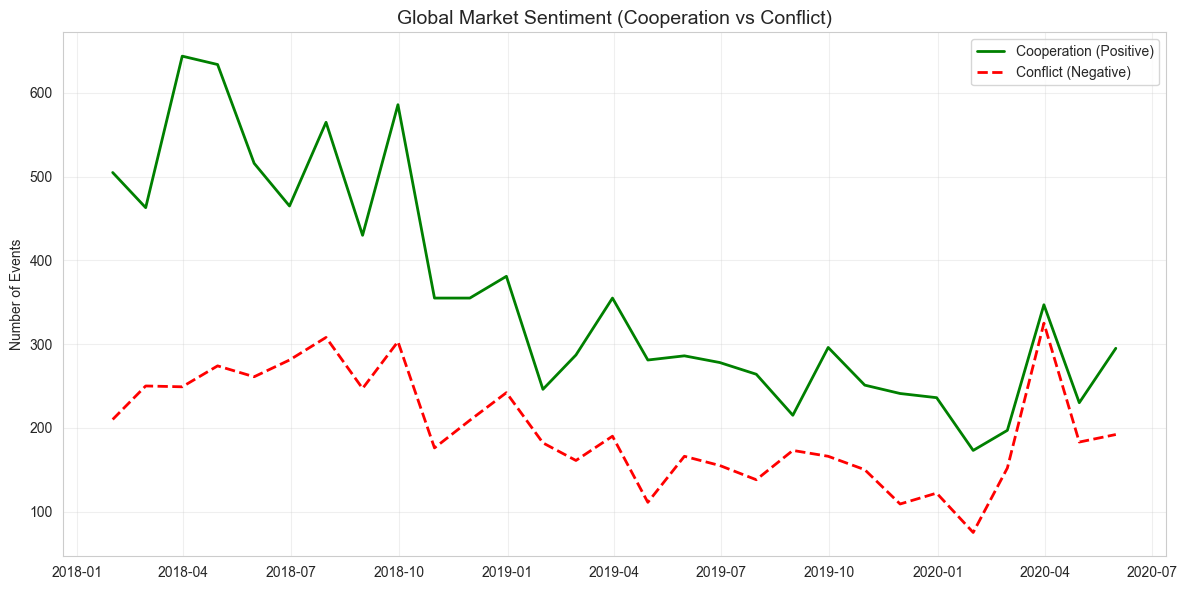

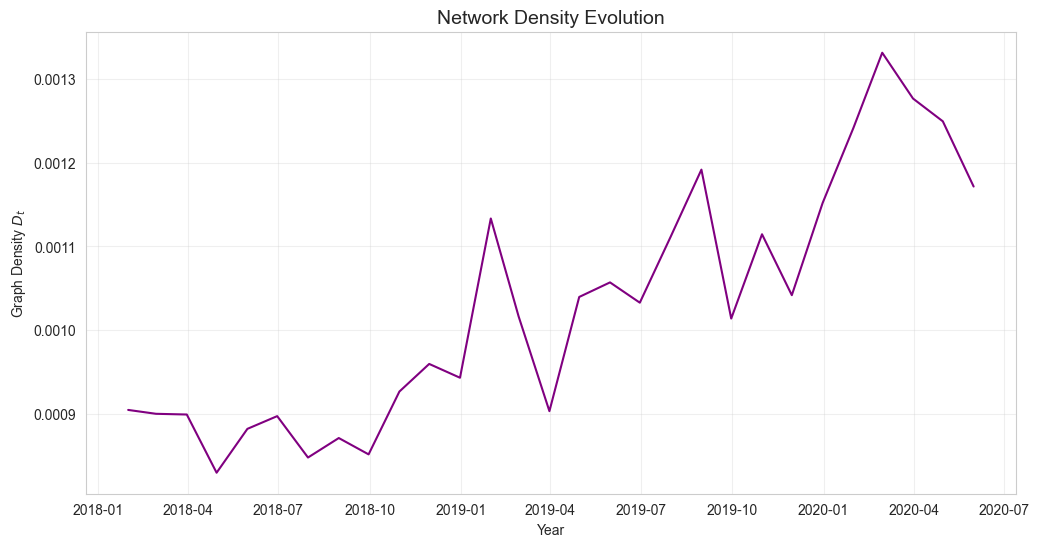

In [13]:
# --- 1. SENTIMENT ANALYSIS (Conflict vs Cooperation) ---

# Define positive and negative relations
pos_rels = ['Invests_In', 'Cooperate', 'Positive_Impact_On', 'Introduce', 'Produce', 'Announce']
neg_rels = ['Sued', 'Sanction', 'Criticize', 'Negative_Impact_On', 'Decrease', 'Reject']

# Create a "Sentiment" column
def get_sentiment(rel):
    if rel in pos_rels: return 'Positive'
    if rel in neg_rels: return 'Negative'
    return 'Neutral'

df['Sentiment'] = df['Relation'].apply(get_sentiment)

# Count monthly sentiment
monthly_sent = df.set_index('Date').groupby([pd.Grouper(freq='ME'), 'Sentiment']).size().unstack(fill_value=0)

# Plot Sentiment
plt.figure(figsize=(12, 6))
plt.plot(monthly_sent.index, monthly_sent['Positive'], label='Cooperation (Positive)', color='green', linewidth=2)
plt.plot(monthly_sent.index, monthly_sent['Negative'], label='Conflict (Negative)', color='red', linewidth=2, linestyle='--')
plt.title("Global Market Sentiment (Cooperation vs Conflict)", fontsize=14)
plt.ylabel("Number of Events")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figure_sentiment.png', dpi=300)
plt.show()


# --- 2. GRAPH DENSITY OVER TIME ---
density_list = []
dates = []

# For each month, calculate graph density
for name, group in df.set_index('Date').resample('ME'):
    if len(group) > 0:
        # Count Nodes (V) and Edges (E) in that month
        nodes = set(group['Subject']).union(set(group['Object']))
        V = len(nodes)
        E = len(group)
        
        # Formula : E / (V * (V-1))
        # If V < 2, density is 0
        if V > 1:
            D = E / (V * (V - 1))
        else:
            D = 0
            
        density_list.append(D)
        dates.append(name)

# Plot Density
plt.figure(figsize=(12, 6))
plt.plot(dates, density_list, color='purple', linewidth=1.5)
plt.title("Network Density Evolution", fontsize=14)
plt.ylabel("Graph Density $D_t$")
plt.xlabel("Year")
plt.grid(True, alpha=0.3)

In [14]:
# --- GRAPH TOPOLOGY VISUALIZATION ---

# --- 1. Filter Dataframe ---
df_graph = df[df["Relation"].isin(["Relate_To", "Operate_In"])]
df_graph = df_graph[["Subject", "Relation", "Object"]] 

# --- 2. Create the Full Graph ---
G_full = nx.from_pandas_edgelist(
    df_graph,
    source="Subject",
    target="Object",
    edge_attr="Relation",
    create_using=nx.DiGraph()
)

# --- 3. Calculate Global Importance ---
pagerank = nx.pagerank(G_full)

# --- 4. Select ONLY the "Titans" (Top 150) ---
top_n = 150
vip_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:top_n]

G_vip = G_full.subgraph(vip_nodes).copy()
G_vip.remove_edges_from(nx.selfloop_edges(G_vip))

# --- 5. The "Cleaner" (k-core = 3) ---
G_final = nx.k_core(G_vip, k=3).copy()

print(f"Final Executive Graph: {G_final.number_of_nodes()} nodes, {G_final.number_of_edges()} edges")

# --- 6. Add Attributes (Color & Size) ---
# Community Detection
communities = louvain_communities(G_final, seed=42)
for i, c in enumerate(communities):
    for n in c:
        G_final.nodes[n]["modularity_class"] = i

# Centrality for Sizing
final_pagerank = nx.pagerank(G_final)
nx.set_node_attributes(G_final, final_pagerank, "pagerank")

# --- 7. Export ---
nx.write_gexf(G_final, "findkg_titans.gexf")
print("Done! Ready for Gephi.")

Final Executive Graph: 143 nodes, 2022 edges
Done! Ready for Gephi.


In [15]:
# --- KNOWLEDGE GRAPH LINK PREDICTION ---

# --- 1. LOAD DATA ---
# Using both train and valid for training 
df_train = create_df(pd.concat([raw_train, raw_valid], ignore_index=True))
df_test = create_df(raw_test)

print(f"Data Loaded: {len(df_train)} Train, {len(df_test)} Test events.")

# --- 2. BUILD GRAPH & EXTRACT METRICS (TRAIN ONLY) ---
G_train = nx.from_pandas_edgelist(
    df_train, 
    'Subject', 
    'Object', 
    edge_attr='Relation', 
    create_using=nx.DiGraph()
)

# Calculate "Knowledge" from the training graph
pagerank_train = nx.pagerank(G_train)
degree_train = dict(G_train.degree())


# --- 3. FEATURE ENGINEERING ---
def get_features(subject, obj, pr_dict, deg_dict):
    """
    Retrieves features for a pair (S, O).
    If a node from Valid/Test was never seen in Train, it gets 0 (Cold Start problem).
    """
    pr_s = pr_dict.get(subject, 0)
    pr_o = pr_dict.get(obj, 0)
    deg_s = deg_dict.get(subject, 0)
    deg_o = deg_dict.get(obj, 0)
    
    return [pr_s, pr_o, deg_s, deg_o, pr_s * pr_o]

# Prepare Feature Matrices
def prepare_dataset(df, pr_dict, deg_dict):
    X = []
    y = df['Relation'].values
    for _, row in df.iterrows():
        X.append(get_features(row['Subject'], row['Object'], pr_dict, deg_dict))
    return np.array(X), y

X_train, y_train_raw = prepare_dataset(df_train, pagerank_train, degree_train)
X_test, y_test_raw = prepare_dataset(df_test, pagerank_train, degree_train)

# --- 4. LABEL ENCODING ---
# We must fit the encoder on ALL known relations to avoid crashing on unseen labels
all_possible_relations = np.unique(np.concatenate([y_train_raw, y_test_raw]))
le = LabelEncoder()
le.fit(all_possible_relations)

y_train = le.transform(y_train_raw)
y_test = le.transform(y_test_raw)

# --- 5. TRAINING & VALIDATION ---
# Initialize Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on TRAIN set
clf.fit(X_train, y_train)

# --- 6. FINAL TESTING ---
print("\n--- Final Test ---")
test_preds = clf.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
print(f"Test Set Accuracy:   {test_acc:.2f}")

# Detailed Report
print("\nDetailed Test Report:")
# We map the numeric predictions back to string names
unique_labels_in_test = np.unique(y_test)
target_names = le.inverse_transform(unique_labels_in_test)
print(classification_report(y_test, test_preds, target_names=target_names, zero_division=0))

# Example Inference
print("Example Inference (Test Set):")
sample_idx = 0
s, o = df_test.iloc[sample_idx]['Subject'], df_test.iloc[sample_idx]['Object']
true_rel = df_test.iloc[sample_idx]['Relation']
pred_rel = le.inverse_transform([test_preds[sample_idx]])[0]

print(f"Entity Pair: {s} -> {o}")
print(f"True Relation: {true_rel}")
print(f"Predicted:     {pred_rel}")

Data Loaded: 130993 Train, 13069 Test events.

--- Final Test ---
Test Set Accuracy:   0.36

Detailed Test Report:
                    precision    recall  f1-score   support

          Announce       0.20      0.09      0.13       247
           Control       0.35      0.50      0.41      2756
          Decrease       0.32      0.20      0.24       164
               Has       0.24      0.13      0.17      1213
            Impact       0.48      0.38      0.43      2270
         Introduce       0.01      0.01      0.01       151
        Invests_In       0.15      0.06      0.09       191
      Is_Member_Of       0.19      0.12      0.15       247
Negative_Impact_On       0.14      0.08      0.10       451
        Operate_In       0.52      0.44      0.48      1800
   Participates_In       0.21      0.10      0.14       270
Positive_Impact_On       0.05      0.02      0.02        65
           Produce       0.33      0.18      0.24       163
             Raise       0.16      0.10     